# Multi-bootstrap for evaluating pretrained LMs

This notebook shows an example of the paired analysis described in Section 4.1 of the paper. This type of analysis is applicable for any kind of intervention that is applied independently to a particular pretraining (e.g. BERT) checkpoint, including:

- Interventions such as intermediate task training or pruning which directly manipulate a pretraining checkpoint.
- Changes to any fine-tuning or probing procedure which is applied after pretraining.

In the most general case, we'll have a set of $k$ pretraining checkpoints (seeds), to which we'll apply our intervention, perform any additional transformations (like fine-tuning), then evaluate a downstream metric $L$ on a finite evaluation set. The multiple bootstrap procedure allows us to account for three sources of variance:

1. Variation between pretraining checkpoints
2. Expected variance due to a finite evaluation set
3. Variation due to fine-tuning or other procedure

## 2M vs. 1M pretraining steps

Here, we'll compare the MultiBERTs models run for 2M steps with those run for 1M steps. We'll use the five pretraining seeds (0,1,2,3,4) for which we have a dense set of checkpoints throughout training, such that we can treat the 2M runs as an "intervention" (training for additional time) over the 1M-step models and perform a paired analysis. From each pretraining checkpoint, we'll run fine-tuning 5 times for each of 4 learning rates, select the best learning rate (treating this as part of the optimization), and then run our multibootstrap procedure.

We'll use MultiNLI for this example, but the code below can easily be modified to run on other tasks.

In [1]:
#@title Import libraries and multibootstrap code
import re
import os

import numpy as np
import pandas as pd
import sklearn.metrics
import scipy.stats

from tqdm.notebook import tqdm  # for progress indicator

import multibootstrap

In [2]:
scratch_dir = "/tmp/multiberts_mnli"
if not os.path.isdir(scratch_dir): 
    os.mkdir(scratch_dir)

preds_root = "https://storage.googleapis.com/multiberts/public/example-predictions/GLUE"
# Fetch development set labels
!curl -O $preds_root/MNLI_dev_labels --output-dir $scratch_dir
# Fetch predictions index file
!curl -O $preds_root/index.tsv --output-dir $scratch_dir

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19630  100 19630    0     0   175k      0 --:--:-- --:--:-- --:--:--  175k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  492k  100  492k    0     0  3020k      0 --:--:-- --:--:-- --:--:-- 3020k


In [3]:
!ls $scratch_dir

index.tsv  MNLI_dev_labels


Load the run metadata. You can also just look through the directory, but this index file is convenient if (as we do here) you only want to download some of the files.

In [4]:
task_name = "MNLI"

run_info = pd.read_csv(os.path.join(scratch_dir, 'index.tsv'), sep='\t')

# Filter to the runs we're interested in
mask = run_info.task == task_name
mask &= run_info.release == 'multiberts'
run_info = run_info[mask].copy()
run_info

,file,task,pretrain_id,n_steps,lr,ft_seed,release
1260,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00002,0,multiberts
1261,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00002,1,multiberts
1262,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00002,2,multiberts
1263,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00002,3,multiberts
1264,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00002,4,multiberts
...,...,...,...,...,...,...,...
1855,"MNLI/release=multiberts,pretrain_id=14,n_steps...",MNLI,14,2M,0.00005,0,multiberts
1856,"MNLI/release=multiberts,pretrain_id=14,n_steps...",MNLI,14,2M,0.00005,1,multiberts
1857,"MNLI/release=multiberts,pretrain_id=14,n_steps...",MNLI,14,2M,0.00005,2,multiberts
1858,"MNLI/release=multiberts,pretrain_id=14,n_steps...",MNLI,14,2M,0.00005,3,multiberts


Load the dev set labels:

In [5]:
ALL_TASKS = list(run_info.task.unique())
print("Tasks:", ALL_TASKS)

task_labels = {}
for task_name in ALL_TASKS:
    labels_file = os.path.join(scratch_dir, task_name + "_dev_labels")
    labels = np.loadtxt(labels_file).astype(float if task_name == 'STS-B' else int)
    task_labels[task_name] = labels

{k:len(v) for k, v in task_labels.items()}

Tasks: ['MNLI']


{'MNLI': 9815}

Load the predictions:

In [6]:
# Download all prediction files
for fname in tqdm(run_info.file):
    !curl $preds_root/$fname -o $scratch_dir/$fname --create-dirs --silent

  0%|          | 0/600 [00:00<?, ?it/s]

In [7]:
!ls $scratch_dir/MNLI

'release=multiberts,pretrain_id=0,n_steps=1M,lr=2e-05,ft_seed=0.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=2e-05,ft_seed=1.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=2e-05,ft_seed=2.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=2e-05,ft_seed=3.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=2e-05,ft_seed=4.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=3e-05,ft_seed=0.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=3e-05,ft_seed=1.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=3e-05,ft_seed=2.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=3e-05,ft_seed=3.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=3e-05,ft_seed=4.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=4e-05,ft_seed=0.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=4e-05,ft_seed=1.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=4e-05,ft_seed=2.tsv'
'release=multiberts,pretrain_id=0,n_steps=1M,lr=4e-05,ft_seed=3.tsv'
'release=multiberts,pretrain_id=0,

In [8]:
# Load all predictions (slow)
def get_preds(preds_tsv_path, task_name):
    """Load predictions, as array of integers."""
    # [num_examples, num_classes]
    preds = np.loadtxt(preds_tsv_path, delimiter="\t")
    # [num_examples]
    if task_name == 'STS-B':
        return preds.astype(float)
    else:
        return np.argmax(preds, axis=1).astype(int)

all_preds = [get_preds(os.path.join(scratch_dir, row['file']), row['task']) 
             for _, row in tqdm(run_info.iterrows(), total=len(run_info))]
run_info['preds'] = all_preds

  0%|          | 0/600 [00:00<?, ?it/s]

Compute the overall score for each run:

In [9]:
def score_row(task, preds, **kw):
    labels = task_labels[task]
    if task == "STS-B":
        metric = lambda x, y: scipy.stats.pearsonr(x, y)[0]
    else:
        metric = sklearn.metrics.accuracy_score
    return metric(preds, labels)

all_scores = [score_row(**row) for _, row in tqdm(run_info.iterrows(), total=len(run_info))]
run_info['score'] = all_scores

  0%|          | 0/600 [00:00<?, ?it/s]

We treat the selection of fine-tuning learning rate as part of the optimiztion process, and select the best learning rate for each task. Do this independently for each pretraining configuration: original BERT, MultiBERTs 1M, and MultiBERTs 2M.

In [10]:
# Find the best finetuning LR for each task
def find_best_lr(sub_df):
    return sub_df.groupby('lr').agg({'score': np.mean})['score'].idxmax()

gb = run_info.groupby(['release', 'n_steps', 'task'])
best_lr = gb.apply(find_best_lr)
best_lr

release     n_steps  task
multiberts  1M       MNLI    0.00003
            2M       MNLI    0.00002
dtype: float64

In [11]:
# Select only runs with the best LR (should be 1/4 of total)
gb = run_info.groupby(['release', 'n_steps', 'task'])

def filter_to_best_lr(sub_df):
    lr = find_best_lr(sub_df)
    return sub_df[sub_df.lr == lr]

best_lr_runs = gb.apply(filter_to_best_lr).reset_index(drop=True)
best_lr_runs

,file,task,pretrain_id,n_steps,lr,ft_seed,release,preds,score
0,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00003,0,multiberts,"[2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, ...",0.840448
1,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00003,1,multiberts,"[2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, ...",0.837086
2,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00003,2,multiberts,"[2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, ...",0.834845
3,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00003,3,multiberts,"[2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, ...",0.839124
4,"MNLI/release=multiberts,pretrain_id=0,n_steps=...",MNLI,0,1M,0.00003,4,multiberts,"[2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, ...",0.839633
...,...,...,...,...,...,...,...,...,...
145,"MNLI/release=multiberts,pretrain_id=14,n_steps...",MNLI,14,2M,0.00002,0,multiberts,"[2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, ...",0.842384
146,"MNLI/release=multiberts,pretrain_id=14,n_steps...",MNLI,14,2M,0.00002,1,multiberts,"[2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, ...",0.844320
147,"MNLI/release=multiberts,pretrain_id=14,n_steps...",MNLI,14,2M,0.00002,2,multiberts,"[2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 1, 2, ...",0.845746
148,"MNLI/release=multiberts,pretrain_id=14,n_steps...",MNLI,14,2M,0.00002,3,multiberts,"[2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, ...",0.841263


## Run multibootstrap (paired)

base (`L`) is MultiBERTs with 1M steps, expt (`L'`) is MultiBERTs with 2M steps. We have five seeds on base, and 25 seeds on expt but only five of these correspond to base seeds, which the `multibootstrap()` code will select automatically. Each seed will have 5 finetuning runs, which will be averaged over inside each sample.

Note that while in the paper we focus on metrics like accuracy that can be expressed as an average point loss, in general the multibootstrap procedure is valid for most common metrics like F1 or BLEU that behave asymptotically like one. As such, our API takes an arbitrary metric function `f(y_pred, y_true)` which will be called on each sample. See the docstring in `multibootstrap.py` for more detail.

In [12]:
num_bootstrap_samples = 1000 #@param {type: "integer"}

mask = (best_lr_runs.release == 'multiberts')
run_df = best_lr_runs[mask]

stats = {}
for task_name in ALL_TASKS:
    print("Task: ", task_name)
    selected_runs = run_df[run_df.task == task_name].copy()
    # Set intervention and seed columns
    selected_runs['intervention'] = selected_runs.n_steps == '2M'
    selected_runs['seed'] = selected_runs.pretrain_id
    print("Available runs:", len(selected_runs))

    labels = task_labels[task_name]
    print("Labels:", labels.dtype, labels.shape)
    preds = np.stack(selected_runs.preds)
    print("Preds:", preds.dtype, preds.shape)

    if task_name == "STS-B":
        metric = lambda x, y: scipy.stats.pearsonr(x, y)[0]
    else:
        metric = sklearn.metrics.accuracy_score

    samples = multibootstrap.multibootstrap(selected_runs, preds, labels,
                                            metric, nboot=num_bootstrap_samples,
                                            paired_seeds=True,
                                            progress_indicator=tqdm)
    stats[task_name] = multibootstrap.report_ci(samples, c=0.95)
    print("")  # newline

pd.concat({k: pd.DataFrame(v) for k,v in stats.items()}).transpose()

Task:  MNLI
Available runs: 150
Labels: int64 (9815,)
Preds: int64 (150, 9815)
Multibootstrap (paired) on 9815 examples
  Common seeds (5): [0, 1, 2, 3, 4]


  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap statistics from 1000 samples:
  E[L]  = 0.837 with 95% CI of (0.831 to 0.844)
  E[L'] = 0.844 with 95% CI of (0.838 to 0.85)
  E[L'-L] = 0.007 with 95% CI of (0.0039 to 0.00991); p-value = 0



MNLI                         
           mean       low      high    p
base   0.837332  0.831248  0.843770  NaN
expt   0.844328  0.838156  0.850376  NaN
delta  0.006996  0.003896  0.009907  0.0

## Plot result distribution

In [13]:
from matplotlib import pyplot
import seaborn as sns
sns.set_style('white')
%config InlineBackend.figure_format = 'retina' # make matplotlib plots look better

<AxesSubplot:title={'center':'MultiBERTs 1M vs 2M'}, xlabel='Pretraining Steps', ylabel='MNLI Accuracy'>

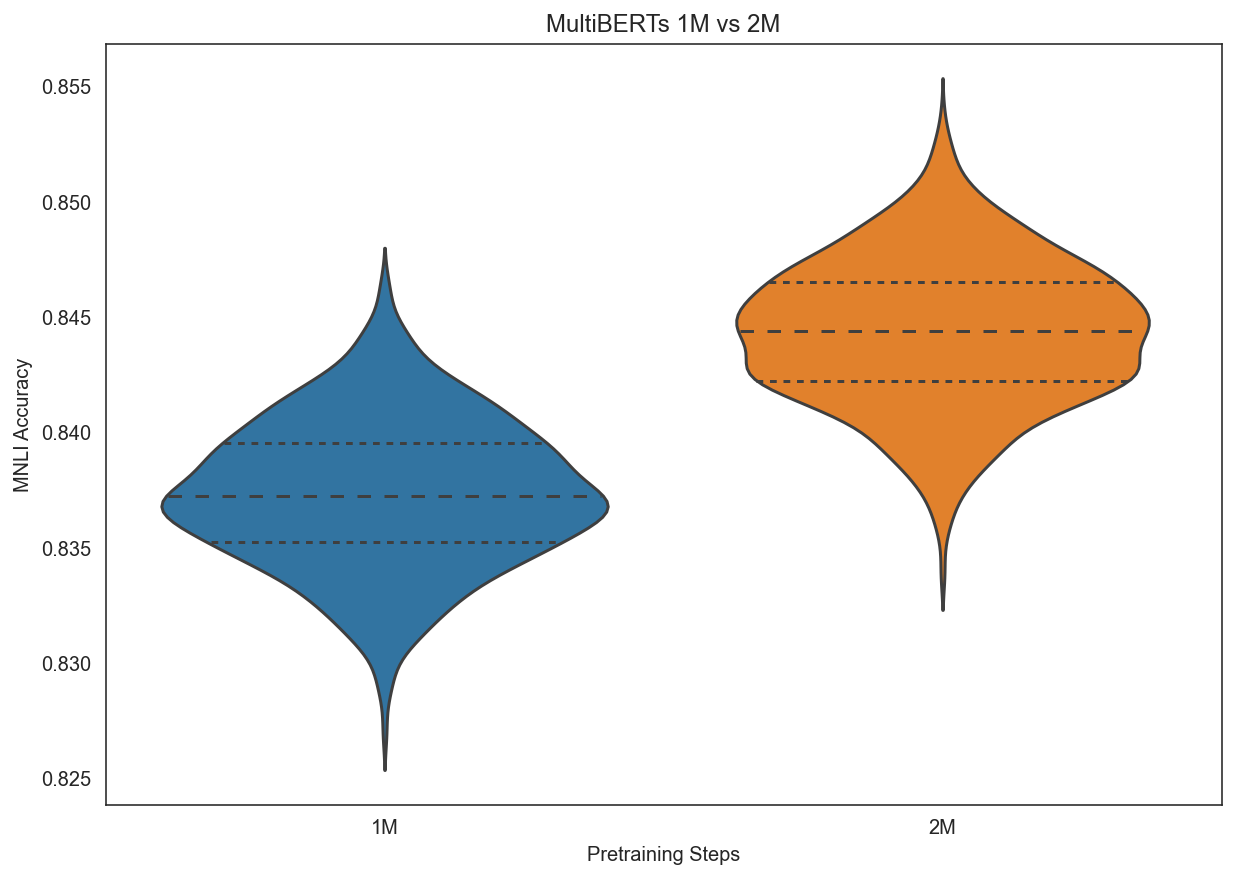

In [14]:
# Plot distribution of scores
var_name = 'Pretraining Steps'
val_name = "MNLI Accuracy"
bdf = pd.DataFrame(samples, columns=['1M', '2M']).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
fig = pyplot.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile')
ax.set_title("MultiBERTs 1M vs 2M")
ax

The distributions of scores from 1M and 2M checkpoints seem to overlap significantly in the above plot, but because these are derived from the same samples of (seeds, examples), they are highly correlated. If we look at deltas, we see that in nearly all cases, the intervention (pretraining to 2M steps) will outperform the base model (1M steps), confirming the p-value of close to zero we computed above.

<AxesSubplot:title={'center':'MultiBERTs 1M vs 2M'}, xlabel='Pretraining Steps', ylabel='MNLI Accuracy delta'>

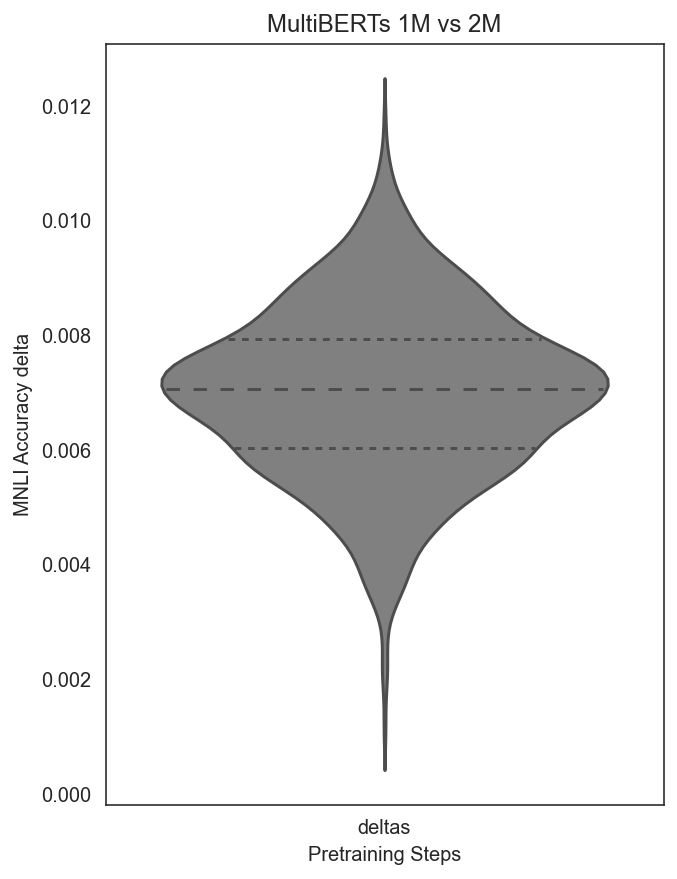

In [15]:
# Plot distribution of deltas L' - L
var_name = 'Pretraining Steps'
val_name = "MNLI Accuracy delta"
bdf = pd.DataFrame(samples, columns=['1M', '2M'])
bdf['deltas'] = bdf['2M'] - bdf['1M']
bdf = bdf.drop(axis=1, labels=['1M', '2M']).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
fig = pyplot.figure(figsize=(5, 7))
ax = fig.gca()
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile',
               palette='gray')
ax.set_title("MultiBERTs 1M vs 2M")
# ax.set_ylim(bottom=0)
ax

This plots the above side-by-side, to create Figure 4 from the paper. Note that the shapes won't match exactly due to randomness, but should be qualitatively similar.

<AxesSubplot:xlabel='Pretraining Steps', ylabel='MNLI Accuracy delta'>

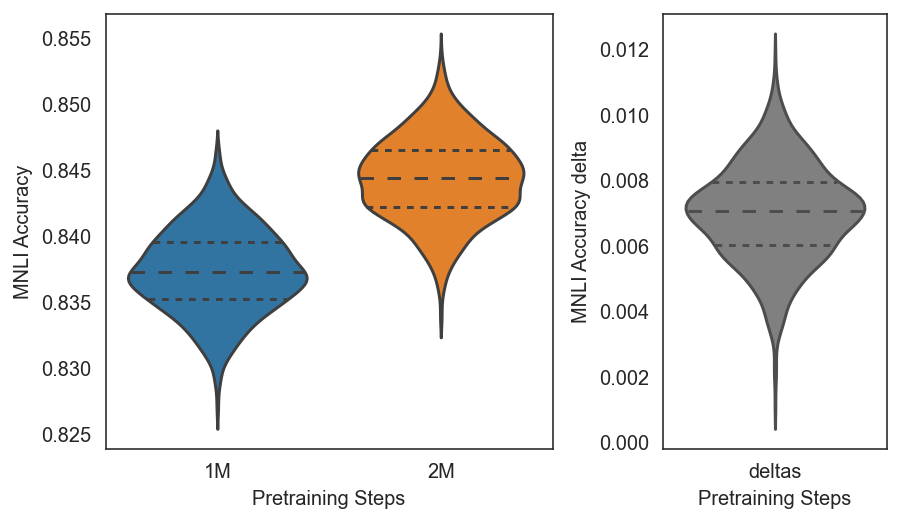

In [16]:
# Plot distribution of results and deltas
fig, (a1, a2) = pyplot.subplots(nrows=1, ncols=2, figsize=(7,4), 
                                gridspec_kw=dict(width_ratios=[2,1], wspace=0.33))


var_name = 'Pretraining Steps'
val_name = "MNLI Accuracy"
bdf = pd.DataFrame(samples, columns=['1M', '2M']).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
sns.violinplot(ax=a1, x=var_name, y=val_name, data=bdf, inner='quartile')

var_name = 'Pretraining Steps'
val_name = "MNLI Accuracy delta"
bdf = pd.DataFrame(samples, columns=['1M', '2M'])
bdf['deltas'] = bdf['2M'] - bdf['1M']
bdf = bdf.drop(axis=1, labels=['1M', '2M']).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
sns.violinplot(ax=a2, x=var_name, y=val_name, data=bdf, inner='quartile',
               palette='gray')